# DLOps Assignment 2: RNN, LSTM and Docker [100 Marks]

### Submitted By Debonil Ghosh [M21AIE225]

Q2. The dataset you have been given is Individual household electric power consumption
dataset. [25]
(i)Split the dataset into train and test (80:20) and do the basic preprocessing. [10]
(ii) Use LSTM to predict the global active power while keeping all other important
features and predict it for the testing days by training the model and plot the real global active
power and predicted global active power for the testing days and comparing the results. [8]
(iii) Now split the dataset in train and test (70:30) and predict the global active power for
the testing days and compare the results with part (ii). [7]

In [181]:
import pandas as pd
import torch
import torch.nn
import torch.optim
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T
from sklearn import metrics
import seaborn as sns
import time
import math
import numpy as np
import matplotlib.pyplot as plt


In [182]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


def get_model_mobilenet_cifar10():
    model = torchvision.models.mobilenet_v2(
        weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2)
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 10)
    model = model.to(device)
    # print(model)
    return model


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Train the model


def model_training(model, criterion, optimizer, trainloader, testloader, num_epochs=10, model_name='model'):
    start = time.time()
    loss_list = []
    with torch.profiler.profile(
            schedule=torch.profiler.schedule(
                wait=1, warmup=1, active=3, repeat=2),
            on_trace_ready=torch.profiler.tensorboard_trace_handler(
                './logs/'+model_name),
            record_shapes=True,
            profile_memory=True,
            with_stack=True
    ) as prof:
        for epoch in range(num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_acc = 0.0
            val_acc = 0.0
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += metrics.accuracy_score(labels.cpu().detach(
                ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
                prof.step()
            # Evaluate the model on the validation set
            with torch.no_grad():
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    val_acc += metrics.accuracy_score(labels.cpu().detach(
                    ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
            train_loss = train_loss/len(trainloader)
            val_loss = val_loss/len(testloader)
            train_acc = train_acc/len(trainloader)
            val_acc = val_acc/len(testloader)
            print(f'Epoch: {epoch+1} ({timeSince(start)}) \tTraining Loss: {train_loss:.3f}, \tTest Loss: {val_loss:.3f},  \tTraining acc: {train_acc:.2f}, \tTest acc: {val_acc:.2f}, ')
            loss_list.append([train_loss, val_loss, train_acc, val_acc])

        print(
            f'Training completed in {timeSince(start)} \tTraining Loss: {loss_list[-1][0]:.3f}, \tTest Loss: {loss_list[-1][1]:.3f},  \tTraining acc: {loss_list[-1][2]:.2f}, \tTest acc: {loss_list[-1][3]:.2f}, ')
        return np.array(loss_list), time.time()-start, loss_list[-1][2], loss_list[-1][3]


# %%
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})


def confusionMatrixAndAccuracyReport(Y_test, Y_pred_probs, label):
    Y_pred = Y_pred_probs.argmax(axis=1)
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    top_5_accuracy = metrics.top_k_accuracy_score(
        Y_test, Y_pred_probs, k=5, labels=np.arange(10))

    plt.figure(figsize=(10, 10))
    plt.title(
        f'Top 1 Accuracy : {overallAccuracy*100:3.2f}% | Top 5 Accuracy : {top_5_accuracy*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues', fmt='g')

    plt.show()
    print(f'Top 1 Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'Top 5 Accuracy: {top_5_accuracy*100}%')
    print(f'Classwise Accuracy Score: \n{classwiseAccuracy}')


# %%
def plot_training_graphs(loss_list):
    fig = plt.figure(figsize=(20, 7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title("Training vs Validation loss")
    plot.plot(loss_list[:, 0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:, 1], linestyle='-', label="Validation Loss")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title("Training vs Validation Accuracy")
    plot.plot(loss_list[:, 2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:, 3], linestyle='-', label="Validation Accuracy")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()


cpu


In [183]:
import pandas as pd
power_series_df = pd.read_csv('../downloads/household_power_consumption.txt', index_col='date', sep=';',
                              na_values=['nan', '?'], infer_datetime_format=True, parse_dates={'date': ['Date', 'Time']}, low_memory=False)

print(power_series_df.shape)
print(power_series_df.describe().to_markdown())


(2075259, 7)
|       |   Global_active_power |   Global_reactive_power |       Voltage |   Global_intensity |   Sub_metering_1 |   Sub_metering_2 |   Sub_metering_3 |
|:------|----------------------:|------------------------:|--------------:|-------------------:|-----------------:|-----------------:|-----------------:|
| count |           2.04928e+06 |             2.04928e+06 |   2.04928e+06 |        2.04928e+06 |      2.04928e+06 |      2.04928e+06 |      2.04928e+06 |
| mean  |           1.09162     |             0.123714    | 240.84        |        4.62776     |      1.12192     |      1.29852     |      6.45845     |
| std   |           1.05729     |             0.112722    |   3.23999     |        4.4444      |      6.15303     |      5.82203     |      8.43715     |
| min   |           0.076       |             0           | 223.2         |        0.2         |      0           |      0           |      0           |
| 25%   |           0.308       |             0.048       | 238

In [218]:
power_series_df.sample(10)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date,,,,,,,
2010-09-25 01:01:00,1.322,0.058,240.86,5.4,0.0,2.0,19.0
2009-10-31 12:03:00,1.260,0.046,243.07,5.2,0.0,0.0,18.0
2009-02-18 21:05:00,0.406,0.064,241.44,1.6,0.0,0.0,0.0
2008-08-06 18:00:00,0.174,0.152,241.00,0.8,0.0,0.0,1.0
2008-01-06 05:24:00,0.230,0.000,244.39,1.0,0.0,0.0,0.0
2008-10-13 06:36:00,1.566,0.090,240.62,6.4,0.0,0.0,18.0
2009-07-09 02:11:00,0.282,0.070,241.15,1.4,0.0,0.0,1.0
2007-07-16 19:26:00,0.440,0.250,235.90,2.0,0.0,0.0,0.0
2009-08-14 22:24:00,0.462,0.160,240.61,2.0,0.0,0.0,1.0


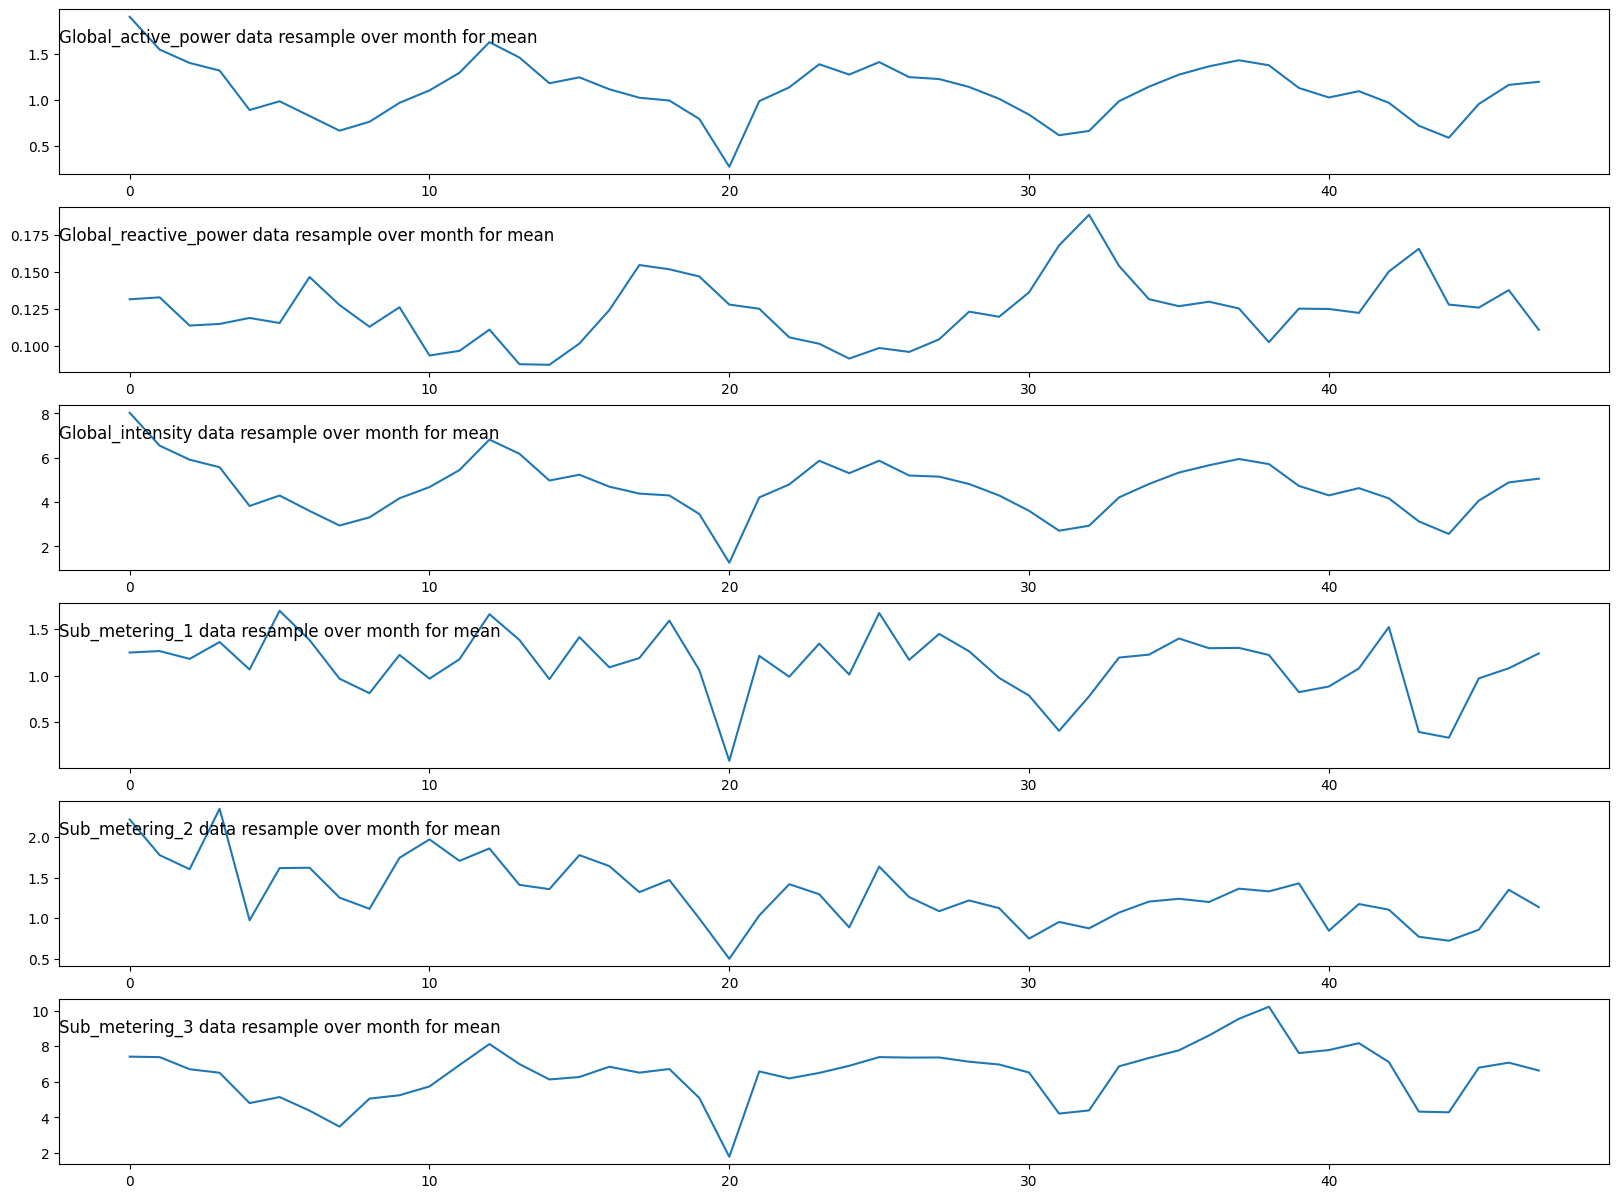

In [219]:
import matplotlib.pyplot as plt

i = 1
cols = [0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 15))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(power_series_df.resample('M').mean().values[:, col])
    plt.title(
        power_series_df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()


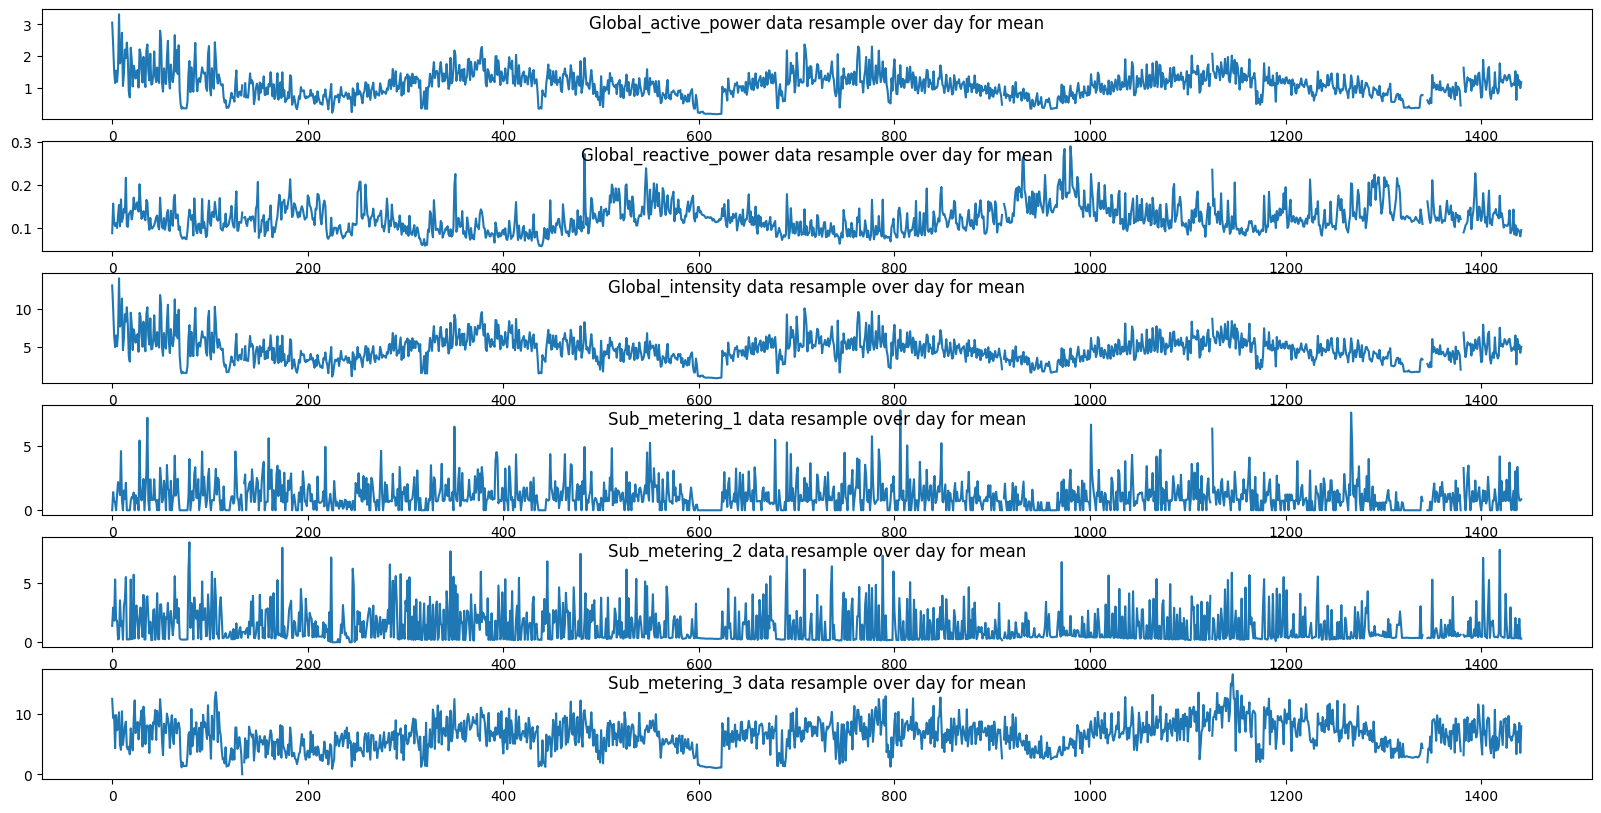

In [220]:
i = 1
cols = [0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(power_series_df.resample('D').mean().values[:, col])
    plt.title(
        power_series_df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()


In [221]:

def reframe_scaled_value(series_data, no_of_inputs, no_of_outputs):
    # print(series_data)
    n_vars = 1 if type(series_data) is list else series_data.shape[1]
    n_vars_arr = [x for x in range (no_of_inputs)]
    series_data_df = pd.DataFrame(series_data)
    print(f'new data famre = {series_data_df}')
    cols, names = list(), list()
    for i in range(no_of_inputs, 0, -1):
        cols.append(series_data_df.shift(-i))
        names.extend([('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]) 
    (f'column names = {names[0:0]}')
    for i in range(0, no_of_outputs):
        cols.append(series_data_df.shift(-i))
        if len(n_vars_arr)< 0:
            n_vars_arr.append(cols)
        if i == 0:
            names.extend([('var%d(t)' % (j+1)) for j in range(n_vars)])
        else:
            names.extend([('var%d(t+%d)' % (j+1)) for j in range(n_vars)])
        #print(f'final output = {series_data_df[0:0]}')
        for _ in n_vars_arr:
            _+=2
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        agg.dropna(inplace=True)
        return agg


In [222]:
df_resample_raw = power_series_df.resample('h')
df_resample = df_resample_raw.mean()
print(f'df_resample.shape => {df_resample.shape}')


df_resample.shape => (34589, 7)


In [223]:
# Data Preprocessing

from sklearn.preprocessing import MinMaxScaler
import math
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = reframe_scaled_value(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()


new data famre =               0         1         2         3    4         5         6
0      0.636816  0.295738  0.337945  0.631157  0.0  0.011366  0.782418
1      0.545045  0.103358  0.335501  0.541487  0.0  0.144652  0.782676
2      0.509006  0.110073  0.283802  0.502152  0.0  0.030869  0.774169
3      0.488550  0.096987  0.315987  0.481110  0.0  0.000000  0.778809
4      0.455597  0.099010  0.434417  0.449904  0.0  0.008973  0.798917
...         ...       ...       ...       ...  ...       ...       ...
34584  0.248876  0.079294  0.431003  0.240794  0.0  0.000000  0.597061
34585  0.225194  0.069350  0.448732  0.219393  0.0  0.000000  0.000000
34586  0.238534  0.077529  0.418395  0.235055  0.0  0.001436  0.000000
34587  0.161531  0.078993  0.520246  0.158178  0.0  0.022972  0.000000
34588  0.125948  0.000000  0.531524  0.118245  0.0  0.000000  0.000000

[34589 rows x 7 columns]


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.455597


In [224]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [225]:
def split_train_test_data(values=reframed.values, split_ratio=0.8):
    values = torch.tensor(values).float()
    split_length = math.floor(len(values) * split_ratio)
    train, test = values[:split_length], values[split_length:]
    train_x, train_y = train[:, :-1], train[:, -1]
    test_x, test_y = test[:, :-1], test[:, -1]
    train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
    test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
    print(f'train_x=>{train_x.shape}, test_x=>{test_x.shape}')
    print(f'train_y=>{train_y.shape}, test_y=>{test_y.shape}')
    return train_x, test_x, train_y, test_y


In [226]:
# Data spliting into train and test data series.80:20
train_x, test_x, train_y, test_y = split_train_test_data(
    values=reframed.values, split_ratio=0.8)


train_x=>torch.Size([27327, 1, 7]), test_x=>torch.Size([6832, 1, 7])
train_y=>torch.Size([27327]), test_y=>torch.Size([6832])


In [227]:

# Define the model

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        #simple model with LSTM
        self.lstm = nn.LSTM(input_size, hidden_size,dropout =1e-1, batch_first=True)
        # and one linear layer
        self.fc_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_output, state = self.lstm(x)
        return self.fc_layer(lstm_output[:, -1, :])

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            # for preds
            y_pred = self.forward(x)
        return y_pred


# Instantiate the LSTM model
model = LSTMModel(input_size=train_x.shape[2], hidden_size=100, output_size=1)

print(f'{model.train()}')


LSTMModel(
  (lstm): LSTM(7, 100, batch_first=True, dropout=0.1)
  (fc_layer): Linear(in_features=100, out_features=1, bias=True)
)


c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [228]:
def plot_training_graphs(loss_list):
    fig = plt.figure(figsize=(20, 7))
    plot = fig.add_subplot(1, 1, 1)
    plot.set_title("Training vs Validation loss")
    plot.plot(loss_list[:, 0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:, 1], linestyle='-', label="Validation Loss")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plt.show()


In [229]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# no of epochs
epoch = 200

# Train the model
loss_list = []
for epoch in range(epoch):
    optimizer.zero_grad()
    output = model(train_x)
    train_loss = criterion(output.squeeze(), train_y)
    train_loss.backward()
    optimizer.step()

    # Evaluate the model on the test data every 10 epochs
    with torch.no_grad():
        test_output = model(test_x.float())
        test_loss = criterion(test_output.squeeze(), test_y)
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch + 10}, Train Loss: {train_loss.item():.6f}, Test Loss: {test_loss.item():.6f}")
    loss_list.append([train_loss.item(), test_loss.item()])


Epoch 10, Train Loss: 0.022605, Test Loss: 0.013458
Epoch 20, Train Loss: 0.018518, Test Loss: 0.012482
Epoch 30, Train Loss: 0.016463, Test Loss: 0.010772
Epoch 40, Train Loss: 0.014593, Test Loss: 0.009337
Epoch 50, Train Loss: 0.012999, Test Loss: 0.008830
Epoch 60, Train Loss: 0.011977, Test Loss: 0.008338
Epoch 70, Train Loss: 0.011563, Test Loss: 0.008461
Epoch 80, Train Loss: 0.011425, Test Loss: 0.008447
Epoch 90, Train Loss: 0.011274, Test Loss: 0.008352
Epoch 100, Train Loss: 0.011118, Test Loss: 0.008161
Epoch 110, Train Loss: 0.010984, Test Loss: 0.008036
Epoch 120, Train Loss: 0.010858, Test Loss: 0.007954
Epoch 130, Train Loss: 0.010738, Test Loss: 0.007882
Epoch 140, Train Loss: 0.010625, Test Loss: 0.007816
Epoch 150, Train Loss: 0.010518, Test Loss: 0.007749
Epoch 160, Train Loss: 0.010419, Test Loss: 0.007685
Epoch 170, Train Loss: 0.010328, Test Loss: 0.007627
Epoch 180, Train Loss: 0.010246, Test Loss: 0.007576
Epoch 190, Train Loss: 0.010174, Test Loss: 0.007533
Ep

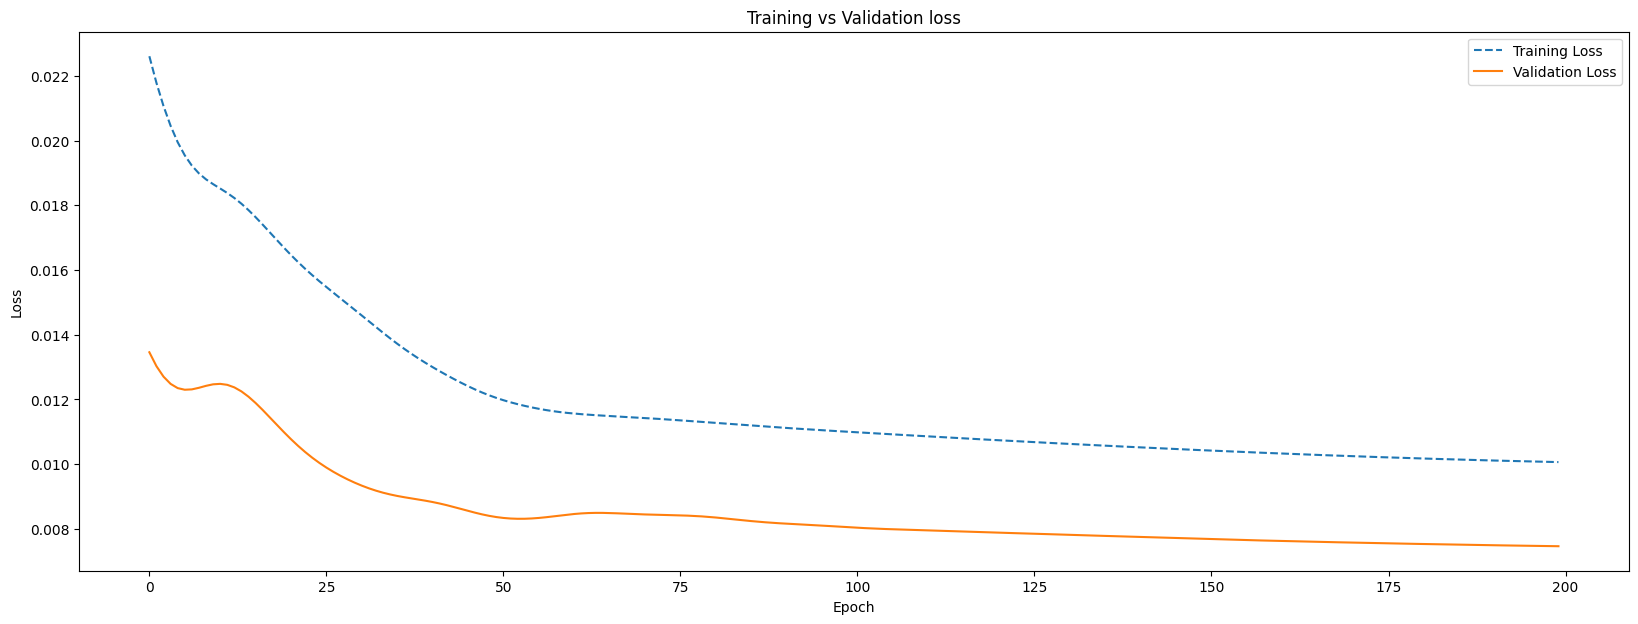

In [230]:

# Plot the loss history
plot_training_graphs(np.array(loss_list))


In [231]:
size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
test_x = test_x.double().numpy()
test_y = test_y.double().numpy()
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
test_y
inv_y = scaler.inverse_transform(inv_y)
#
inv_y = inv_y[:, 0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


# Mean squared error in Test dataset
mean_squared_error = mean_squared_error(inv_y, inv_yhat)
print(f'Root Mean squared error in Test dataset : {mean_squared_error:.3f}')
# Root Mean squared error in Test dataset

root_mean_squared_error = np.sqrt(mean_squared_error)
print(
    f'Root Mean squared error in Test dataset : {root_mean_squared_error:.3f}')


Test RMSE: 0.556


(6832,)
(6832,)


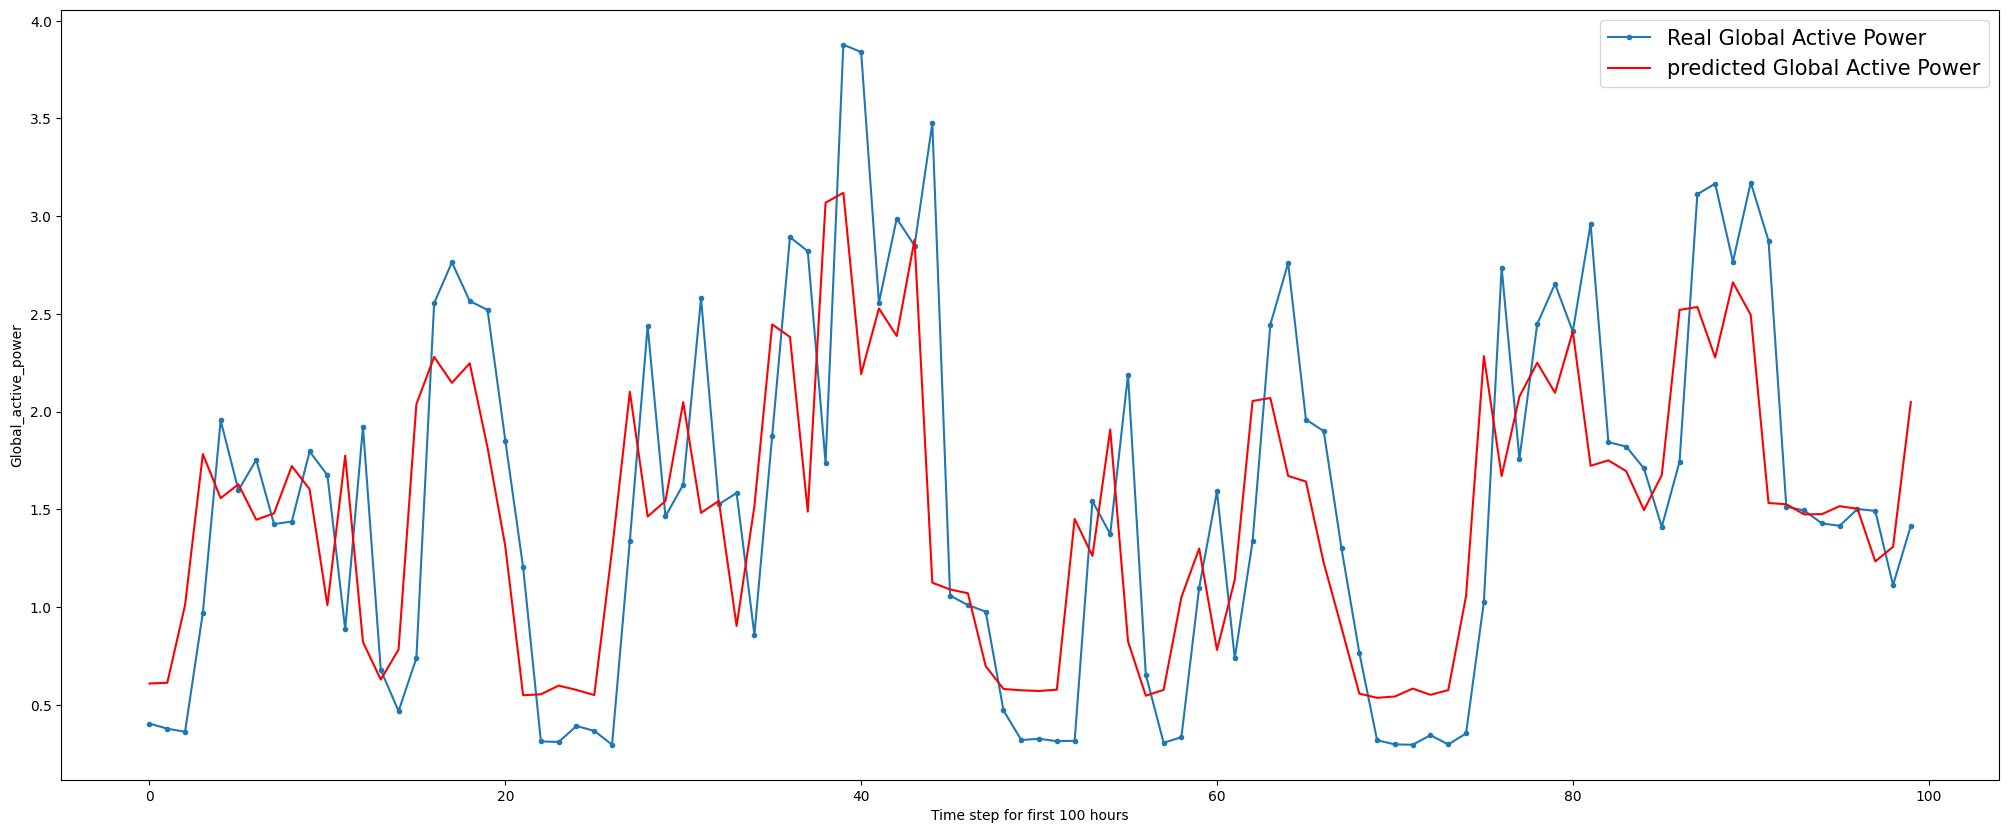

In [232]:
print(f'{inv_y.shape}')

print(f'{inv_yhat.shape}')
comp = pd.DataFrame({"Real_Global_Active_power": inv_y,
                    "Predicted_Global_Active_power": inv_yhat})

aa = [x for x in range(100)]
plt.figure(figsize=(25, 10))
plt.plot(aa, inv_y[:100], marker='.', label="Real Global Active Power")
plt.plot(aa, inv_yhat[:100], 'r', label="predicted Global Active Power")
#
plt.ylabel(power_series_df.columns[0])
plt
plt.xlabel('Time step for first 100 hours')
plt.legend(fontsize=15)
plt.show()


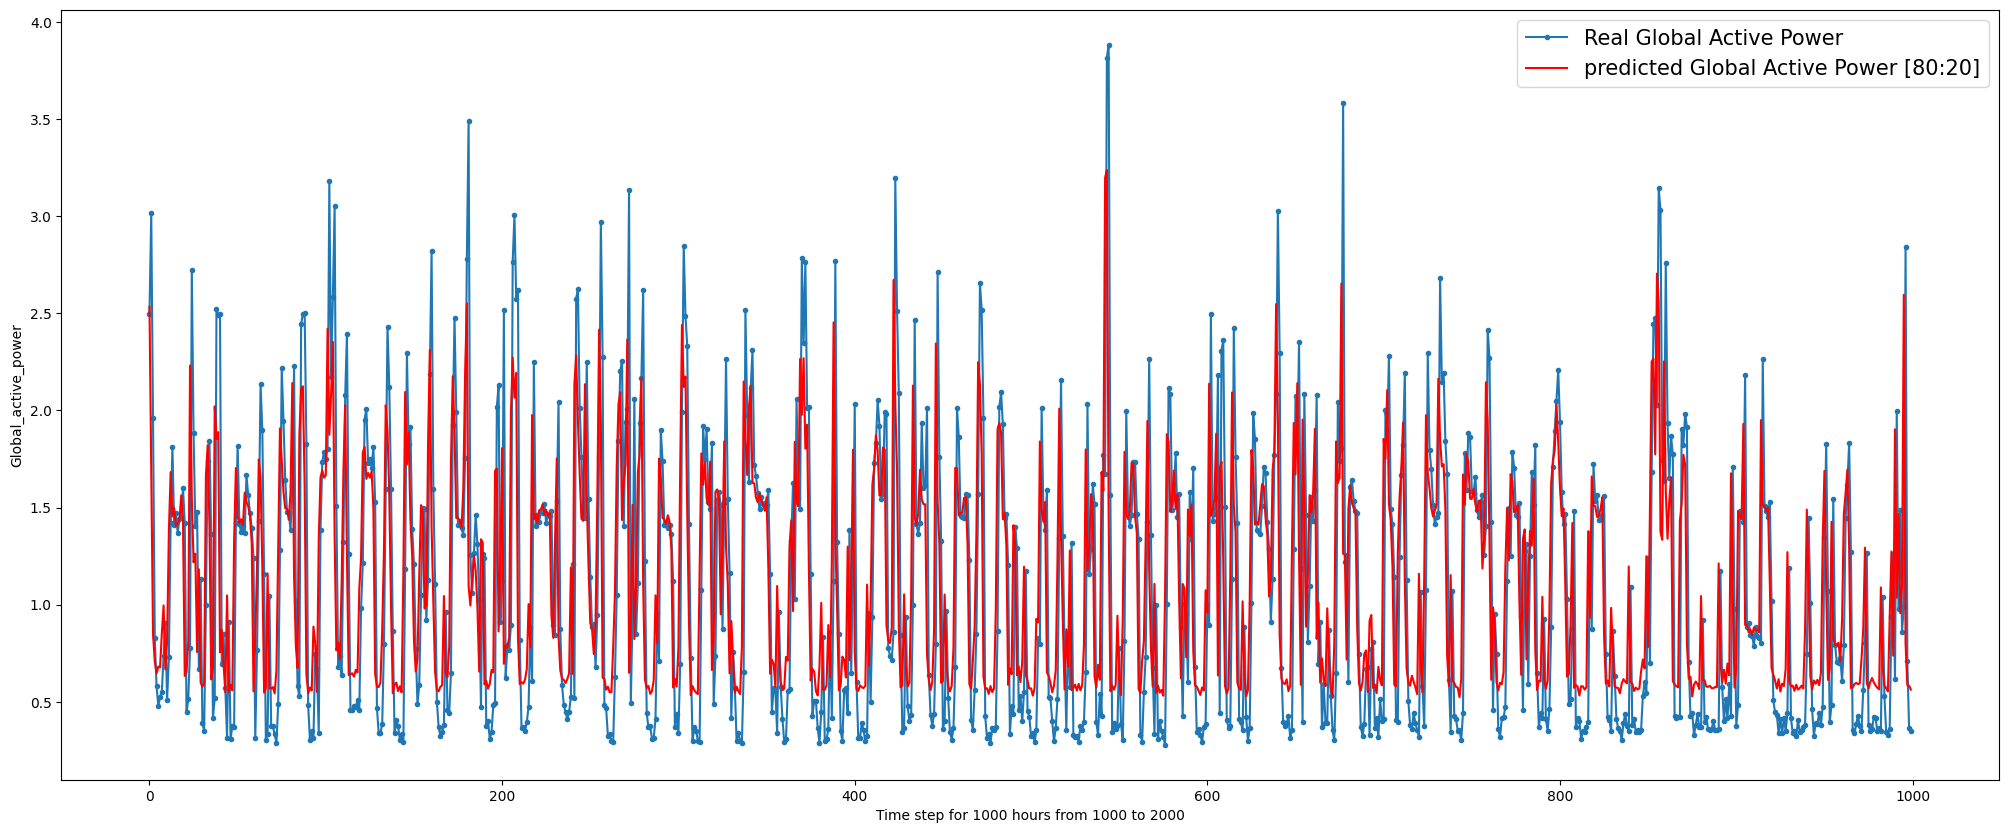

In [233]:
aa = [x for x in range(1000)]
plt.figure(figsize=(25, 10))
plt.plot(aa, inv_y[1000:2000], marker='.', label="Real Global Active Power")
plt.plot(aa, inv_yhat[1000:2000], 'r',
         label="predicted Global Active Power [80:20]")
plt.ylabel(power_series_df.columns[0])
plt
plt.xlabel('Time step for 1000 hours from 1000 to 2000')
#
plt.legend(fontsize=15)
plt.show()


In [234]:
# Data spliting into train and test data series.70:30
train_x_70, test_x_30, train_y_70, test_y_30 = split_train_test_data(
    values=reframed.values, split_ratio=0.7)


train_x=>torch.Size([23911, 1, 7]), test_x=>torch.Size([10248, 1, 7])
train_y=>torch.Size([23911]), test_y=>torch.Size([10248])


In [235]:
# Define the loss function and optimizer
# Initialize the model
model_70_30 = LSTMModel(
    input_size=train_x.shape[2], hidden_size=100, output_size=1)

print(model_70_30)
criterion_70_30 = nn.MSELoss()
optimizer_70_30 = optim.Adam(model_70_30.parameters(), lr=0.001)

# no of epochs
epoch = 200

# Train the model
loss_list_70_30 = []
for epoch in range(epoch):
    optimizer_70_30.zero_grad()
    output = model_70_30(train_x_70)
    train_loss = criterion_70_30(output.squeeze(), train_y_70)
    train_loss.backward()
    optimizer_70_30.step()

    # Evaluate the model on the test data every 10 epochs
    with torch.no_grad():
        test_output = model_70_30(test_x_30.float())
        test_loss = criterion_70_30(test_output.squeeze(), test_y_30)
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch + 10}, Train Loss: {train_loss.item():.6f}, Test Loss: {test_loss.item():.6f}")
    loss_list_70_30.append([train_loss.item(), test_loss.item()])


LSTMModel(
  (lstm): LSTM(7, 100, batch_first=True, dropout=0.1)
  (fc_layer): Linear(in_features=100, out_features=1, bias=True)
)


c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 10, Train Loss: 0.046353, Test Loss: 0.040021
Epoch 20, Train Loss: 0.025112, Test Loss: 0.019602
Epoch 30, Train Loss: 0.015771, Test Loss: 0.011790
Epoch 40, Train Loss: 0.015115, Test Loss: 0.012077
Epoch 50, Train Loss: 0.014147, Test Loss: 0.011073
Epoch 60, Train Loss: 0.013113, Test Loss: 0.010081
Epoch 70, Train Loss: 0.012535, Test Loss: 0.009662
Epoch 80, Train Loss: 0.012002, Test Loss: 0.009430
Epoch 90, Train Loss: 0.011667, Test Loss: 0.009303
Epoch 100, Train Loss: 0.011442, Test Loss: 0.009168
Epoch 110, Train Loss: 0.011308, Test Loss: 0.009125
Epoch 120, Train Loss: 0.011213, Test Loss: 0.009118
Epoch 130, Train Loss: 0.011131, Test Loss: 0.009080
Epoch 140, Train Loss: 0.011050, Test Loss: 0.009028
Epoch 150, Train Loss: 0.010968, Test Loss: 0.008980
Epoch 160, Train Loss: 0.010885, Test Loss: 0.008926
Epoch 170, Train Loss: 0.010803, Test Loss: 0.008873
Epoch 180, Train Loss: 0.010721, Test Loss: 0.008824
Epoch 190, Train Loss: 0.010639, Test Loss: 0.008775
Ep

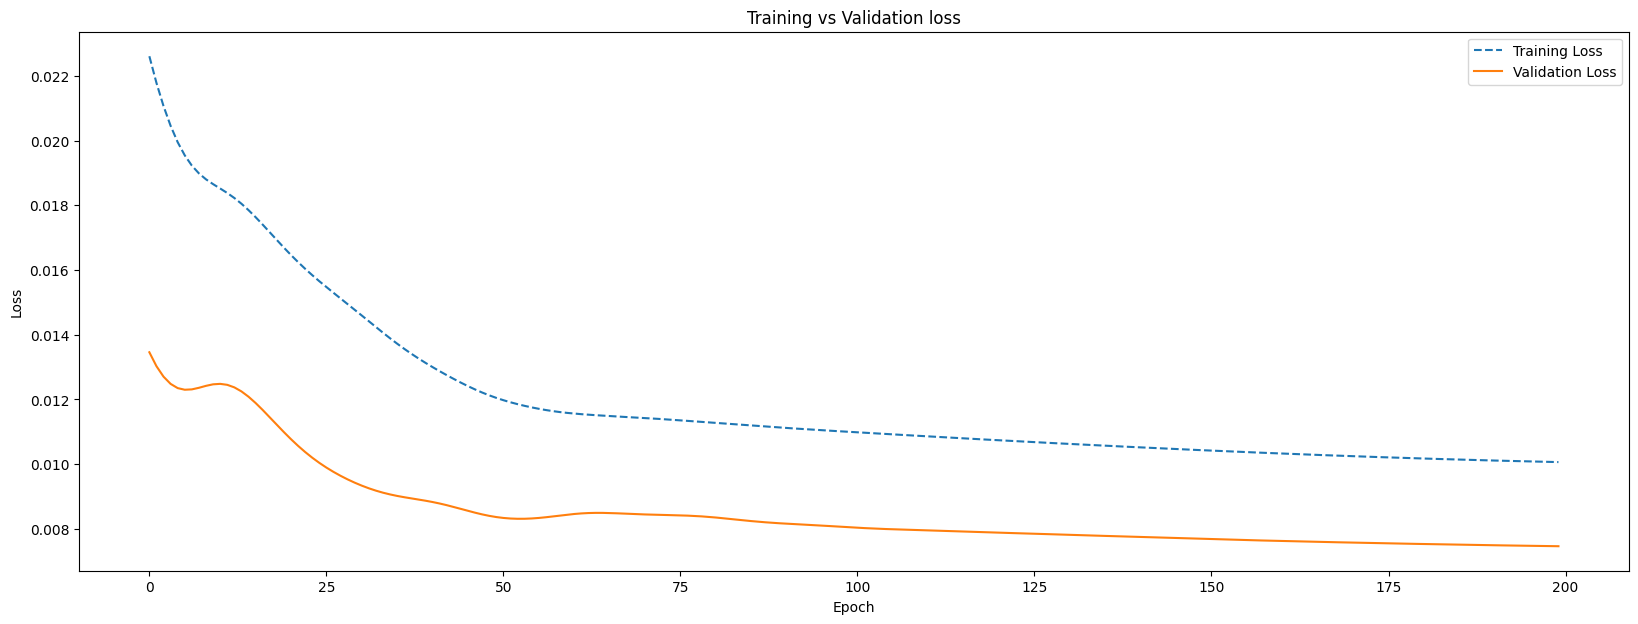

In [236]:
# Plot the loss history
plot_training_graphs(np.array(loss_list))


In [237]:
size = df_resample.shape[1]

# Prediction test
yhat_30 = model.predict(test_x_30)
test_x_30 = test_x_30.reshape((test_x_30.shape[0], size))

# invert scaling for prediction
inv_yhat_new_30 = np.concatenate((yhat_30, test_x_30[:, 1-size:]), axis=1)
inv_yhat_new_30 = scaler.inverse_transform(inv_yhat_new_30)
inv_yhat_new_30 = inv_yhat_new_30[:, 0]

# invert scaling for actual
test_y_30 = test_y_30.reshape((len(test_y_30), 1))
inv_y_30 = np.concatenate((test_y_30, test_x_30[:, 1-size:]), axis=1)
inv_y_30 = scaler.inverse_transform(inv_y_30)
inv_y_30 = inv_y_30[:, 0]

# Mean squared error in Test dataset
mean_squared_error_30 = mean_squared_error(inv_y_30, inv_yhat_new_30)
print(f'Root Mean squared error in Test dataset : {mean_squared_error_30:.3f}')
# Root Mean squared error in Test dataset

root_mean_squared_error_30 = np.sqrt(mean_squared_error_30)
print(
    f'Root Mean squared error in Test dataset : {root_mean_squared_error_30:.3f}')


Root Mean squared error in Test dataset : 0.349
Root Mean squared error in Test dataset : 0.591


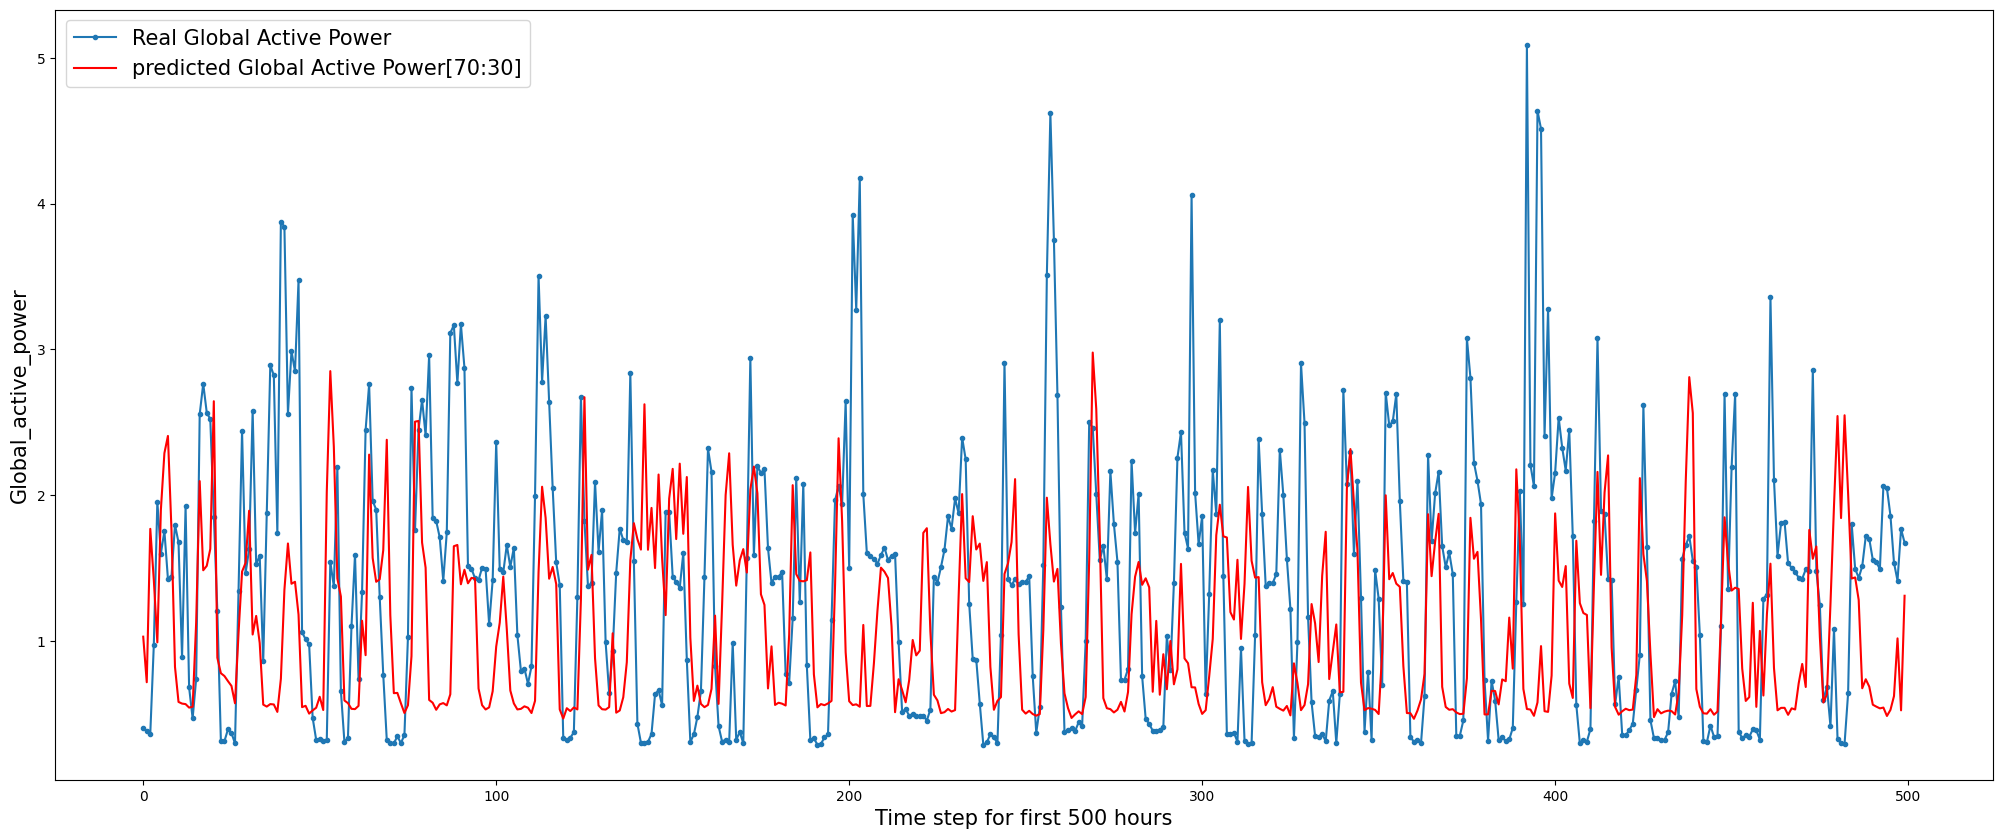

In [238]:
aa = [x for x in range(500)]
plt.figure(figsize=(25, 10))
plt.plot(aa, inv_y[:500], marker='.', label="Real Global Active Power")
plt.plot(aa, inv_yhat_new_30[:500], 'r',
         label="predicted Global Active Power[70:30]")
plt.ylabel(power_series_df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()


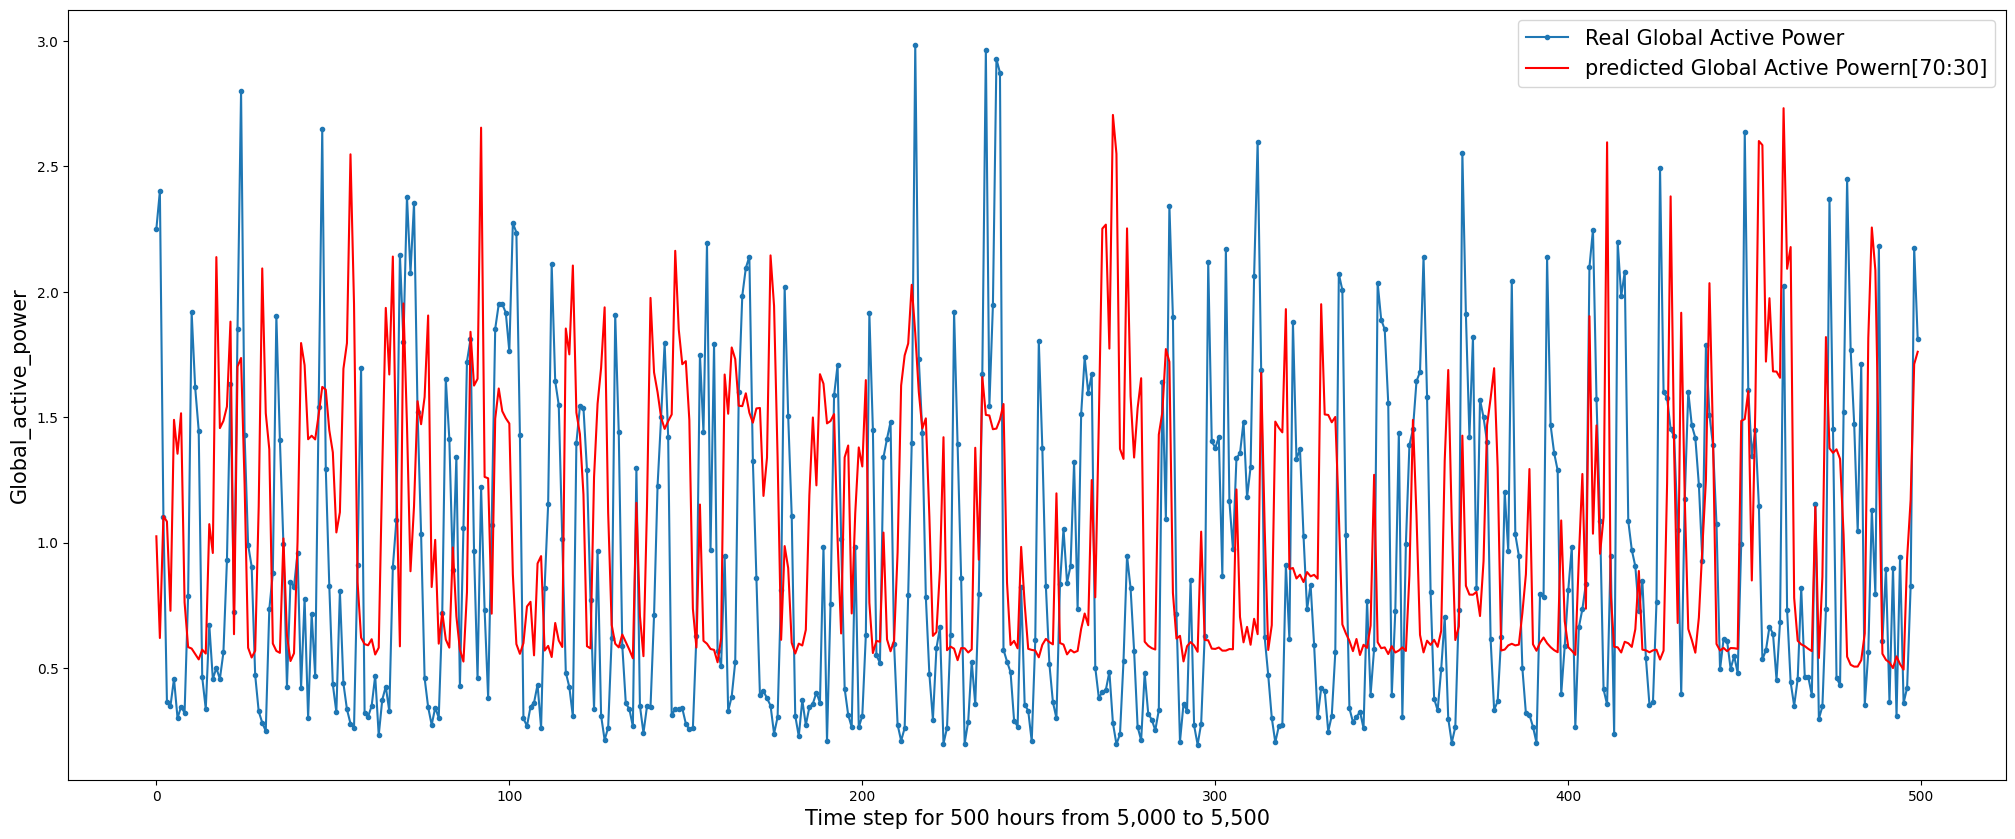

In [239]:
comp['Predicted Global Active Power[70:30]'] = inv_yhat_new_30[0:6832]
aa = [x for x in range(500)]
plt.figure(figsize=(25, 10))
plt.plot(aa, inv_y[5000:5500], marker='.', label="Real Global Active Power")
plt.plot(aa, inv_yhat_new_30[5000:5500], 'r',
         label="predicted Global Active Powern[70:30]")
plt.ylabel(power_series_df.columns[0], size=15)
plt.xlabel('Time step for 500 hours from 5,000 to 5,500', size=15)
plt.legend(fontsize=15)
plt.show()


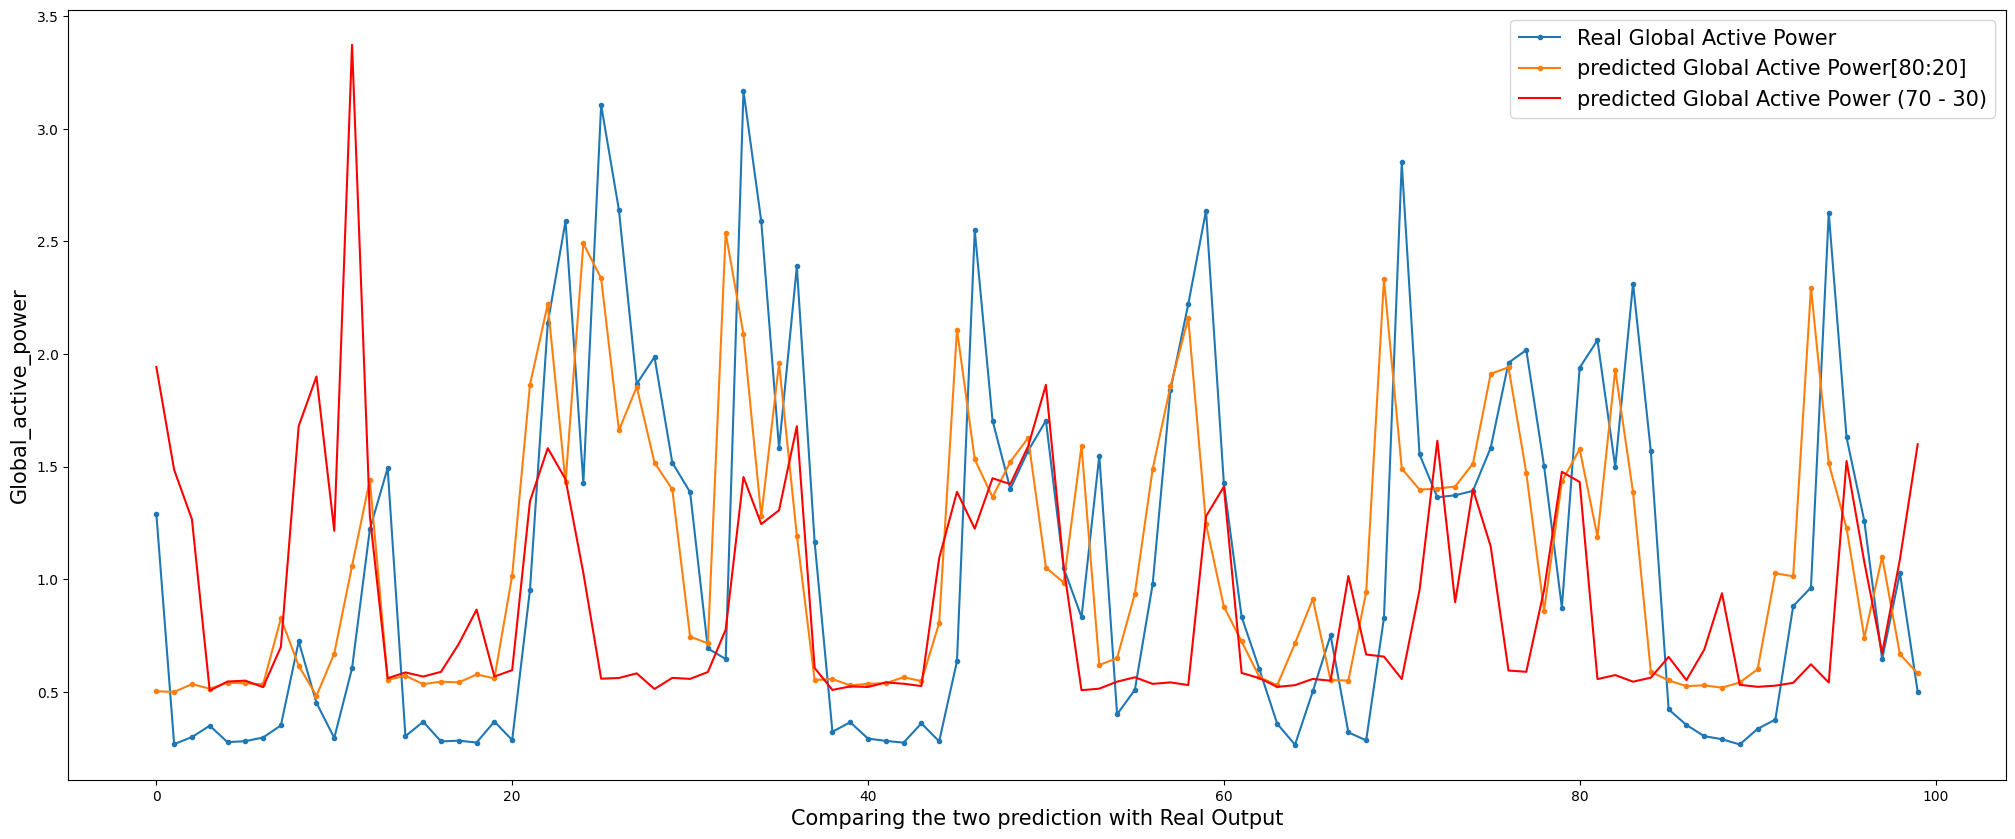

In [240]:
comp.shape
aa = [x for x in range(100)]
plt.figure(figsize=(25, 10))
plt.plot(aa, inv_y[6700:6800], marker='.', label="Real Global Active Power")
plt.plot(aa, inv_yhat[6700:6800], marker='.',
         label="predicted Global Active Power[80:20]")
plt.__doc__
plt.plot(aa, inv_yhat_new_30[6700:6800], 'r',
         label="predicted Global Active Power (70 - 30)")
print
plt.ylabel(power_series_df.columns[0], size=15)
plt.xlabel('Comparing the two prediction with Real Output', size=15)
plt.legend(fontsize=15)
plt.show()


In [241]:
comp.sample(20)


,Real_Global_Active_power,Predicted_Global_Active_power,Predicted Global Active Power[70:30]
5354,0.995300,1.454937,0.568758
2948,1.401333,1.666811,0.872292
1085,0.527267,1.871782,1.411183
470,1.426167,1.322037,0.840957
587,1.443967,1.117408,0.574296
3916,1.061300,1.407536,0.733345
3496,0.848067,0.588785,2.410549
4741,0.368367,0.581714,1.306301
6161,0.965067,1.342135,0.683641
5299,1.403433,1.431915,0.578052
